In [1]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
#from transformers import BertTokenizer, TFBertModel
from tensorflow.python import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from tensorflow.keras.layers import GlobalAveragePooling1D, Concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow import keras
import string
import re
string.punctuation
from keras.models import Sequential
from tensorflow.keras import models, layers, metrics
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import spacy

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = "/content/drive/My Drive/Capstone/data/depression_pre.csv"
pre = pd.read_csv(path)

path2 = "/content/drive/My Drive/Capstone/data/depression_post.csv"
post = pd.read_csv(path2)

In [5]:
pre_txt = pre[["Post Text"]]
post_txt = post[["Post Text"]]

In [6]:
pre_txt['Post Text'].fillna('', inplace=True)
pre_txt.dropna(subset=['Post Text'], inplace=True)
post_txt['Post Text'].fillna('', inplace=True)
post_txt.dropna(subset=['Post Text'], inplace=True)

def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

pre_txt['Post Text'] = pre_txt['Post Text'].apply(remove_punctuations)
post_txt['Post Text'] = post_txt['Post Text'].apply(remove_punctuations)

pre_txt['Post Text'] = pre_txt['Post Text'].replace('\n','', regex=True)
post_txt['Post Text'] = post_txt['Post Text'].replace('\n','', regex=True)

pre_txt['Post Text'] = pre_txt['Post Text'].str.lower()
post_txt['Post Text'] = post_txt['Post Text'].str.lower()

<ipython-input-6-02cac1242bd2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_txt['Post Text'].fillna('', inplace=True)
<ipython-input-6-02cac1242bd2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_txt.dropna(subset=['Post Text'], inplace=True)
<ipython-input-6-02cac1242bd2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_txt['Post Text'].fillna('', inplace=True)
<ipython-input-6-02cac1242bd2>:4: SettingWithCopyWarnin

In [7]:
pre_txt['covid'] = 'pre'
post_txt['covid'] = 'post'

df = pd.concat([pre_txt, post_txt])

<ipython-input-7-a7ffcb74f5af>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_txt['covid'] = 'pre'
<ipython-input-7-a7ffcb74f5af>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_txt['covid'] = 'post'


In [8]:
df_pre = df[df['covid']=='pre']
df_post = df[df['covid']=='post']

df_post_downsample = df_post.sample(df_pre.shape[0])
df_post_downsample.shape

df_balanced = pd.concat([df_pre, df_post_downsample])
df_balanced.shape

df_balanced['label'] = df_balanced.covid.map({'pre':0, 'post':1})

In [9]:
df_balanced = df_balanced.rename(columns={"Post Text": "text"})

In [10]:
X = df_balanced['text']
y=np.unique(df_balanced['label'], return_inverse=True)[1]

In [13]:
import transformers

In [14]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [15]:
X_list=X.to_list()
X_pt = tokenizer(X_list, padding='max_length', max_length = 512, truncation=True, return_tensors='pt')["input_ids"]

y_list=y.tolist()
y_pt = torch.Tensor(y_list).long()

In [16]:
X_pt_train, X_pt_test, y_pt_train, y_pt_test = train_test_split(X_pt, y_pt, test_size=0.3, random_state=42, stratify=y_pt)

In [17]:
from torch.utils.data import Dataset, DataLoader
class BBCNewsDataset(Dataset):
    """Custom-built BBC News dataset"""

    def __init__(self, X, y):
        """
        Args:
            X, y as Torch tensors
        """
        self.X_train = X
        self.y_train = y


    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, idx):
        return self.X_train[idx], self.y_train[idx]
# Get train and test data in form of Dataset class
train_data_pt = BBCNewsDataset(X=X_pt_train, y=y_pt_train)
test_data_pt = BBCNewsDataset(X=X_pt_test, y=y_pt_test)

In [18]:
train_loader_pt = DataLoader(train_data_pt, batch_size=32)
test_loader_pt = DataLoader(test_data_pt, batch_size=32)

In [19]:
config = transformers.DistilBertConfig(dropout=0.2, attention_dropout=0.2)
dbert_pt = transformers.DistilBertModel.from_pretrained('distilbert-base-uncased', config=config)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [20]:
sample = X_pt_train[0:5]
print('Object type: ', type(dbert_pt(sample)))
print('Output format (shape): ',dbert_pt(sample)[0].shape)
print('Output used as input for the classifier (shape): ', dbert_pt(sample)[0][:,0,:].shape)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Object type:  <class 'transformers.modeling_outputs.BaseModelOutput'>
Output format (shape):  torch.Size([5, 512, 768])
Output used as input for the classifier (shape):  torch.Size([5, 768])


In [21]:
from torch import nn
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [22]:
class DistilBertClassification(nn.Module):
    def __init__(self):
        super(DistilBertClassification, self).__init__()
        self.dbert = dbert_pt
        self.dropout = nn.Dropout(p=0.2)
        self.linear1 = nn.Linear(768,64)
        self.ReLu = nn.ReLU()
        self.linear2 = nn.Linear(64,5)

    def forward(self, x):
        x = self.dbert(input_ids=x)
        x = x["last_hidden_state"][:,0,:]
        x = self.dropout(x)
        x = self.linear1(x)
        x = self.ReLu(x)
        logits = self.linear2(x)
        # No need for a softmax, because it is already included in the CrossEntropyLoss
        return logits

model_pt = DistilBertClassification().to(device)


In [23]:
print(model_pt)

DistilBertClassification(
  (dbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.2, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.2, inplace=False)
            (lin1

In [24]:
for param in model_pt.dbert.parameters():
    param.requires_grad = False

In [25]:
total_params = sum(p.numel() for p in model_pt.parameters())
total_params_trainable = sum(p.numel() for p in model_pt.parameters() if p.requires_grad)
print("Number of parameters: ", total_params)
print("Number of trainable parameters: ", total_params_trainable)

Number of parameters:  66412421
Number of trainable parameters:  49541


In [35]:
import datetime

print(datetime.datetime.now())

from datetime import datetime as dt

print(dt.now())

2024-04-22 18:41:07.033331
2024-04-22 18:41:07.042469


In [37]:
epochs = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_pt.parameters())
from tqdm import tqdm
# Define the dictionary "history" that will collect key performance indicators during training
history = {}
history["epoch"]=[]
history["train_loss"]=[]
history["valid_loss"]=[]
history["train_accuracy"]=[]
history["valid_accuracy"]=[]

# Measure time for training
start_time = dt.now()

In [38]:
for e in range(epochs):

    # Set mode in train mode
    model_pt.train()

    train_loss = 0.0
    train_accuracy = []

    # Loop on batches
    for X, y in tqdm(train_loader_pt):

        # Get prediction & loss
        prediction = model_pt(X)
        loss = criterion(prediction, y)

        # Adjust the parameters of the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        prediction_index = prediction.argmax(axis=1)
        accuracy = (prediction_index==y)
        train_accuracy += accuracy

    train_accuracy = (sum(train_accuracy) / len(train_accuracy)).item() # Calculate the loss on the test data after each epoch
    # Set mode to evaluation (by opposition to training)
    model_pt.eval()
    valid_loss = 0.0
    valid_accuracy = []
    for X, y in test_loader_pt:

        prediction = model_pt(X)
        loss = criterion(prediction, y)

        valid_loss += loss.item()

        prediction_index = prediction.argmax(axis=1)
        accuracy = (prediction_index==y)
        valid_accuracy += accuracy
    valid_accuracy = (sum(valid_accuracy) / len(valid_accuracy)).item()

    # Populate history
    history["epoch"].append(e+1)
    history["train_loss"].append(train_loss / len(train_loader_pt))
    history["valid_loss"].append(valid_loss / len(test_loader_pt))
    history["train_accuracy"].append(train_accuracy)
    history["valid_accuracy"].append(valid_accuracy)

    print(f'Epoch {e+1} \t\t Training Loss: {train_loss / len(train_loader_pt) :10.3f} \t\t Validation Loss: {valid_loss / len(test_loader_pt) :10.3f}')
    print(f'\t\t Training Accuracy: {train_accuracy :10.3%} \t\t Validation Accuracy: {valid_accuracy :10.3%}')# Measure time for training
end_time = datetime.now()
training_time_pt = (end_time - start_time).total_seconds()

100%|██████████| 15/15 [09:42<00:00, 38.84s/it]


Epoch 1 		 Training Loss:      0.979 		 Validation Loss:      0.716
		 Training Accuracy:    49.453% 		 Validation Accuracy:    48.223%


100%|██████████| 15/15 [09:47<00:00, 39.14s/it]


Epoch 2 		 Training Loss:      0.698 		 Validation Loss:      0.737
		 Training Accuracy:    52.735% 		 Validation Accuracy:    46.701%


100%|██████████| 15/15 [09:41<00:00, 38.74s/it]


Epoch 3 		 Training Loss:      0.699 		 Validation Loss:      0.719
		 Training Accuracy:    53.392% 		 Validation Accuracy:    55.330%


100%|██████████| 15/15 [09:28<00:00, 37.88s/it]


Epoch 4 		 Training Loss:      0.683 		 Validation Loss:      0.707
		 Training Accuracy:    55.580% 		 Validation Accuracy:    56.853%


100%|██████████| 15/15 [09:11<00:00, 36.77s/it]


Epoch 5 		 Training Loss:      0.682 		 Validation Loss:      0.710
		 Training Accuracy:    54.705% 		 Validation Accuracy:    56.345%


AttributeError: module 'datetime' has no attribute 'now'

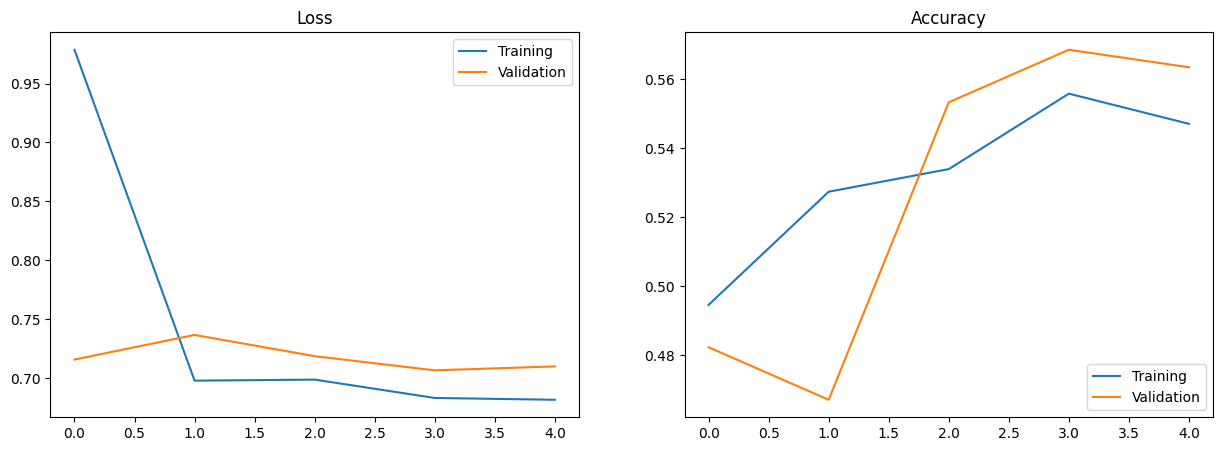

In [39]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set(title='Loss')
ax[0].plot(history['train_loss'], label='Training')
ax[0].plot(history['valid_loss'], label='Validation')
ax[0].legend(loc="upper right")

ax[1].set(title='Accuracy')
ax[1].plot(history['train_accuracy'], label='Training')
ax[1].plot(history['valid_accuracy'], label='Validation')
ax[1].legend(loc="lower right")

In [40]:
accuracy_pt = history['valid_accuracy'][-1]
print('Accuracy Training data: {:.1%}'.format(history['train_accuracy'][-1]))
print('Accuracy Test data: {:.1%}'.format(history['valid_accuracy'][-1]))
print('Training time: {:.1f}s (or {:.1f} minutes)'.format(training_time_pt, training_time_pt/60))

Accuracy Training data: 54.7%
Accuracy Test data: 56.3%


NameError: name 'training_time_pt' is not defined

In [41]:
torch.save(model_pt.state_dict(), 'PyModel.sd')
model_reloaded = DistilBertClassification()
model_reloaded.load_state_dict(torch.load('PyModel.sd'))
model_reloaded.eval()

DistilBertClassification(
  (dbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.2, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.2, inplace=False)
            (lin1

In [56]:
import torch
from transformers import BertTokenizer, BertModel
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [58]:
pre = df_balanced[df_balanced['covid'] == 'pre']

In [60]:
documents = pre['text']

In [61]:
stop_words = set(stopwords.words('english'))

In [62]:
tokenized_documents = [doc.split() for doc in documents]

In [63]:
for doc in documents:
    word_tokens = word_tokenize(doc)
    filtered_doc = [word for word in word_tokens if word.lower() not in stop_words]
    #filtered_doc_2 = [word for word in filtered_doc if word.lower() not in custom_stopwords]
    tokenized_documents.append(filtered_doc)

In [64]:
dictionary = Dictionary(tokenized_documents)
gensim_corpus = [dictionary.doc2bow(doc) for doc in tokenized_documents]

In [65]:
lda_model = LdaModel(gensim_corpus, num_topics=5, id2word=dictionary)

In [66]:
topics = lda_model.show_topics(num_topics=-1, num_words=10)

In [67]:
for topic in topics:
    print(topic)

(0, '0.034*"i" + 0.029*"and" + 0.028*"to" + 0.024*"the" + 0.018*"a" + 0.016*"of" + 0.014*"my" + 0.010*"that" + 0.009*"me" + 0.009*"for"')
(1, '0.027*"i" + 0.019*"and" + 0.014*"the" + 0.010*"to" + 0.010*"like" + 0.010*"im" + 0.010*"a" + 0.009*"feel" + 0.009*"’" + 0.008*"of"')
(2, '0.017*"’" + 0.012*"im" + 0.008*"to" + 0.008*"i" + 0.007*"get" + 0.007*"life" + 0.007*"dont" + 0.007*"even" + 0.006*"want" + 0.005*"my"')
(3, '0.041*"i" + 0.027*"to" + 0.018*"and" + 0.014*"like" + 0.013*"’" + 0.013*"the" + 0.013*"a" + 0.011*"my" + 0.011*"feel" + 0.010*"it"')
(4, '0.015*"i" + 0.014*"to" + 0.013*"like" + 0.009*"’" + 0.009*"feel" + 0.008*"and" + 0.008*"get" + 0.008*"my" + 0.008*"im" + 0.007*"people"')


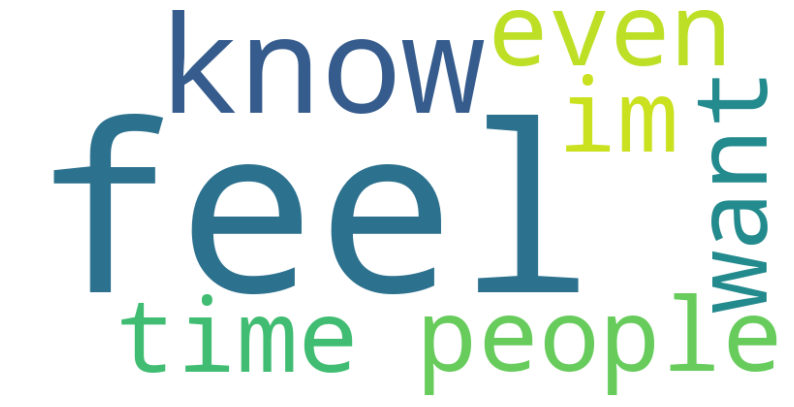

In [81]:
topics = lda_model.show_topics(num_topics=-1, num_words=10)

all_words = ' '.join([word for topic, words in topics for word, _ in lda_model.show_topic(topic)])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)


plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [72]:
post = df_balanced[df_balanced['covid'] == 'post']

In [73]:
documents = post['text']

In [74]:
stop_words = set(stopwords.words('english'))

In [75]:
tokenized_documents = [doc.split() for doc in documents]

In [76]:
for doc in documents:
    word_tokens = word_tokenize(doc)
    filtered_doc = [word for word in word_tokens if word.lower() not in stop_words]
    #filtered_doc_2 = [word for word in filtered_doc if word.lower() not in custom_stopwords]
    tokenized_documents.append(filtered_doc)

In [77]:
dictionary = Dictionary(tokenized_documents)
gensim_corpus = [dictionary.doc2bow(doc) for doc in tokenized_documents]

In [78]:
lda_model = LdaModel(gensim_corpus, num_topics=5, id2word=dictionary)

(0, '0.025*"and" + 0.024*"i" + 0.023*"to" + 0.020*"the" + 0.016*"my" + 0.012*"a" + 0.010*"me" + 0.009*"but" + 0.009*"of" + 0.009*"you"')
(1, '0.037*"’" + 0.008*"i" + 0.007*"know" + 0.007*"like" + 0.006*"people" + 0.006*"the" + 0.006*"time" + 0.005*"and" + 0.005*"get" + 0.005*"even"')
(2, '0.014*"like" + 0.014*"to" + 0.014*"i" + 0.013*"want" + 0.012*"’" + 0.012*"my" + 0.011*"feel" + 0.010*"im" + 0.010*"and" + 0.007*"the"')
(3, '0.022*"i" + 0.021*"’" + 0.014*"and" + 0.013*"to" + 0.013*"the" + 0.011*"like" + 0.010*"of" + 0.009*"my" + 0.009*"feel" + 0.007*"was"')
(4, '0.055*"i" + 0.032*"to" + 0.024*"and" + 0.016*"a" + 0.015*"my" + 0.014*"the" + 0.013*"it" + 0.011*"me" + 0.010*"that" + 0.009*"of"')


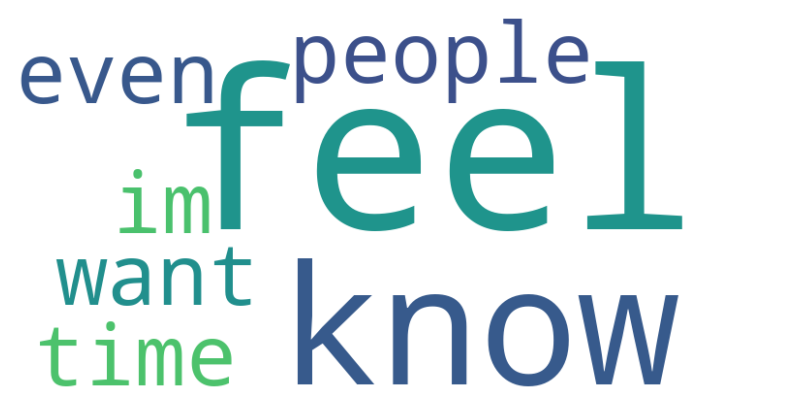

In [82]:
topics = lda_model.show_topics(num_topics=-1, num_words=10)

for topic in topics:
    print(topic)

topics = lda_model.show_topics(num_topics=-1, num_words=10)

all_words = ' '.join([word for topic, words in topics for word, _ in lda_model.show_topic(topic)])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)


plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()